# Imágenes como conjuntos de datos

Las imágenes son un tipo de datos fundamental para un cientifíco de datos que resuelve tareas de visión por computador. A diferencia de otro tipo de datos las imágenes son multidimensionales y contienen información enriquecida además de unicamente su tamaño (alto x ancho). Cada pixel contiene tambiéén la información de su intensidad, de modo que un objeto tipo imagen tiene un tamaño (alto,ancho) y por cada coordenada un valor de intensidad en una escala de 0 a 1. 

![](https://drive.google.com/uc?id=1-CFgFy0f6Mkb0496sb4MgR60SoCX-F9_)


Por otro lado las imágenes a color tienen 3 canales diferentes (asociado a las escalas RGB - Rojo, Verde y azul), de modo que el tamaño de un objeto tipo imagen a color es (alto, ancho, canales) donde cada pixel contiene la información de intensidad en las escalas rojo, azul y verde. Esta escala varía entre 0 y 255 a diferencia de la escala de grises.


![](https://drive.google.com/uc?id=18Txu65iVgA08Gq7xjLxZp8s3A3N1GnEp)


Algunas imágenes continen un cuarto canal asociado al brillo de cada pixel, en este caso en nemero de canales es 4 y se les reconoce como las escalas RGBA.



# Ejercicio

En este notebook identificaremos uno de los errores más comúnes al momento de entrenar modelos de aprendizaje; el cruce de datos de entrenamiento y evaluación. 

Para identificar este error visualizaremos curvas de *loss*, *f1_score* y *accuracy*.

## Leer los datos tipo imágenes

In [ ]:
#-- Descomprimimos el dataset
# !rm -r mnist
# !unzip mnist.zip

In [ ]:
#--- Buscamos las direcciones de cada archivo de imagen
from glob import glob

train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/8/2213.png'

In [ ]:
#--- Ordenamos los datos de forma aleatoria para evitar sesgos
import numpy as np

np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

## Primer caso: Sin cruce

In [ ]:
#--- Cargamos los datos de entrenamiento en listas
from PIL import Image

N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [ ]:
#--- Cargamos los datos de validación en listas
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [ ]:
#--- Cargamos los datos de testeo en listas
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

In [ ]:
#--- Visualizamos el tamaño de cada subset
len(X_train), len(X_valid), len(X_test)

(6000, 2000, 992)

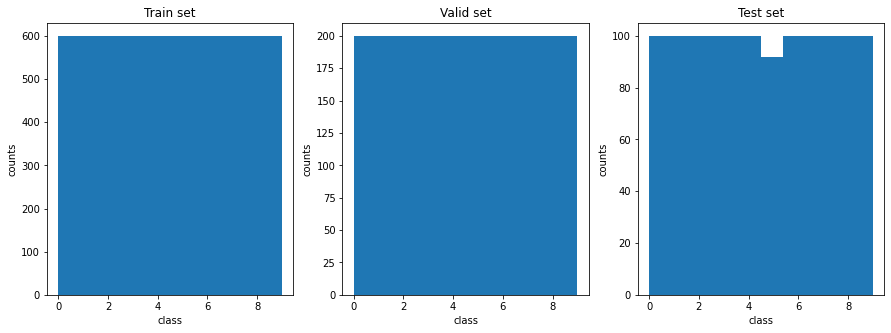

In [ ]:
#--- Visualizamos la distribución de clases en cada subset
from PIL import Image
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.hist(np.sort(Y_train))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Train set')

plt.subplot(1,3,2)
plt.hist(np.sort(Y_valid))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Valid set')

plt.subplot(1,3,3)
plt.hist(np.sort(Y_test))
plt.xlabel('class')
plt.ylabel('counts')
plt.title('Test set')

plt.show()

Este dataset cuenta con un total de 900 objetos por clase (600 para entrenamiento, 200 para validación y 100 para testeo), este es un ejemplo donde las clases están balanceadas, no siempre se tendrán datos de esta forma. 

Considerando el total de datos de este dataset,~66% son datos de entrenamiento, otro ~22% de validación y un ~11% para testeo. Esto representa un buen ejemplo de cómo distribuir los datos para entrenar sus modelos.

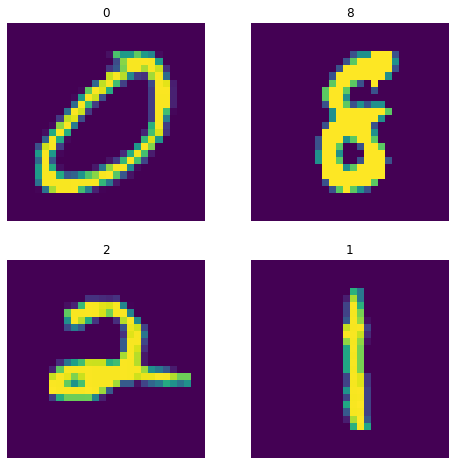

In [ ]:
#-- Visualizamos los datos
fig = plt.figure(figsize=(8,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.imshow(X_test[i*15])
  plt.title(Y_test[i*15])
  plt.axis(False)
plt.show()

In [ ]:
#--- Convertimos las listas de datos a tensores de torch
import torch
from torch.autograd import Variable

X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [ ]:
#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 100

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import f1_score # Nueva métrica (La revisaremos la próóxima sesión)

#-- Número de épocas
n_epoch = 100

#-- Listas de evaluación entrenamiento
loss_train = []
f1_train = []
acc_train = []

#-- Listas de evaluación validación
loss_valid = []
f1_valid = []
acc_valid = []

#-- Entrenamineto de la ANN
for epoch in range(n_epoch):
  model.train()
  
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)  

Epoch [1/100], loss: 30.726638793945312. f1:0.049693729428166654 acc: 0.0860000029206276 
Epoch [2/100], loss: 20.70538902282715. f1:0.14150775958272083 acc: 0.1678333282470703 
Epoch [3/100], loss: 13.299518585205078. f1:0.29652565852112506 acc: 0.32466667890548706 
Epoch [4/100], loss: 9.05010986328125. f1:0.4265155653965538 acc: 0.44216665625572205 
Epoch [5/100], loss: 6.72088098526001. f1:0.512917898645197 acc: 0.5261666774749756 
Epoch [6/100], loss: 4.147376537322998. f1:0.6346126650189834 acc: 0.6299999952316284 
Epoch [7/100], loss: 2.903877019882202. f1:0.7238329840510183 acc: 0.7179999947547913 
Epoch [8/100], loss: 2.6643669605255127. f1:0.7485212677023363 acc: 0.7446666955947876 
Epoch [9/100], loss: 2.664947748184204. f1:0.764006646686188 acc: 0.7601666450500488 
Epoch [10/100], loss: 2.571340799331665. f1:0.7799061668530651 acc: 0.7774999737739563 
Epoch [11/100], loss: 2.298602342605591. f1:0.8003469423517438 acc: 0.8011666536331177 
Epoch [12/100], loss: 2.014052391052

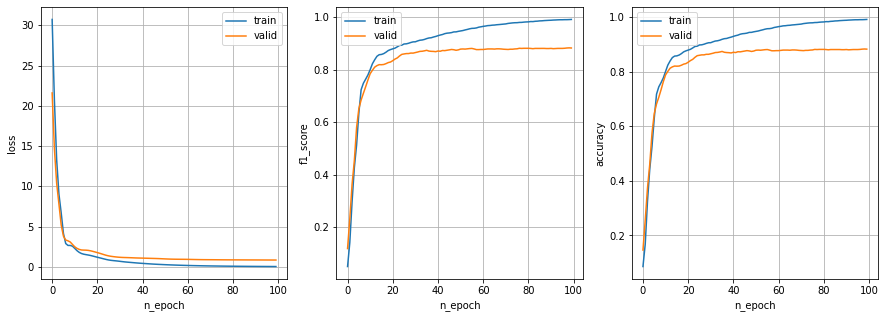

In [ ]:
#-- Visualizamos las curvas de entrenamiento y validación

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_ok.png', bbox_inches='tight')
plt.show()

In [ ]:
#-- Evaluamos el modelo entrenado con el set de testeo

model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.7988482117652893, f1: 0.8911014907562402, acc: 0.8921371102333069


## Segundo caso: Cruzando train+valid

In [ ]:
#--- Cargamos los datos de entrenamiento + validación en listas

N_train = len(train_files)+len(valid_files)
X_train = []
Y_train = []

for i, train_file in enumerate( train_files+valid_files ):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [ ]:
#--- Convetimos las listas con los datos a tensores de torch
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_train.data.size()

torch.Size([8000, 28, 28])

In [ ]:
#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 100

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)  
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import f1_score

n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

for epoch in range(n_epoch):
  model.train()
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)  

Epoch [1/100], loss: 24.935379028320312. f1:0.08877327005345716 acc: 0.12287499755620956 
Epoch [2/100], loss: 16.986467361450195. f1:0.19346097420624614 acc: 0.24062499403953552 
Epoch [3/100], loss: 11.937654495239258. f1:0.3421944619804739 acc: 0.3840000033378601 
Epoch [4/100], loss: 7.717433452606201. f1:0.49733629402722557 acc: 0.5095000267028809 
Epoch [5/100], loss: 4.312788486480713. f1:0.6457572613383306 acc: 0.6488749980926514 
Epoch [6/100], loss: 3.23726749420166. f1:0.7073250424716708 acc: 0.7118750214576721 
Epoch [7/100], loss: 3.423774003982544. f1:0.7106714194621787 acc: 0.7282500267028809 
Epoch [8/100], loss: 3.425701141357422. f1:0.7242243387657818 acc: 0.7425000071525574 
Epoch [9/100], loss: 2.891451597213745. f1:0.7536568357683155 acc: 0.7634999752044678 
Epoch [10/100], loss: 2.2422738075256348. f1:0.7945298092496607 acc: 0.7963749766349792 
Epoch [11/100], loss: 1.916025161743164. f1:0.8233836345191848 acc: 0.8236250281333923 
Epoch [12/100], loss: 1.810096502

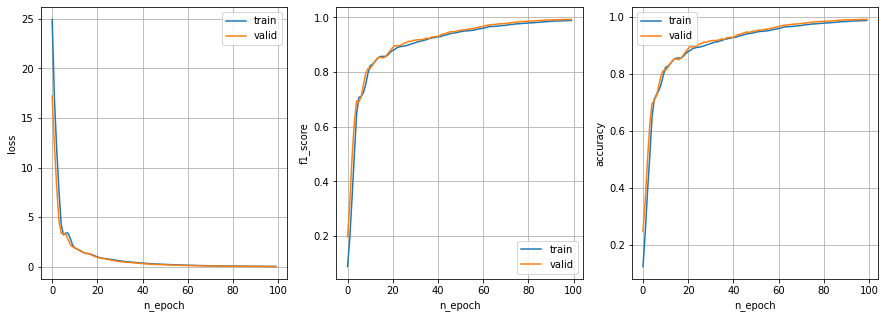

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_tr_vd.png', bbox_inches='tight')
plt.show()

In [ ]:
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.6401269435882568, f1: 0.914266650964948, acc: 0.9143145084381104


## Tercer caso: Cruzando train+test

In [ ]:
#--- Cargamos los datos de entrenamiento + testeo en listas

N_train = len(train_files)+len(test_files)
X_train = []
Y_train = []

for i, train_file in enumerate( train_files+test_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [ ]:
#--- Convetimos las listas con los datos a tensores de torch
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_train.data.size()

torch.Size([6992, 28, 28])

In [ ]:
#--- Definimos una ANN con dos capas ocultas lineales de 100 neuronas

input_dim = 28*28
out_dim = 10
hidden = 100

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)  test
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
from sklearn.metrics import f1_score

n_epoch = 100

loss_train = []
f1_train = []
acc_train = []

loss_valid = []
f1_valid = []
acc_valid = []

for epoch in range(n_epoch):
  model.train()
  Xtr = X_train.view(X_train.size(0), -1)
  Y_pred = model(Xtr)

  loss = criterion(Y_pred,Y_train)
  loss_train.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
  
  acc = sum(Y_train == Y_pred)/len(Y_pred)
  acc_train.append(acc)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )

  model.eval()
  Xvl = X_valid.view(X_valid.size(0), -1)
  Y_pred = model(Xvl)  
  loss = criterion(Y_pred,Y_valid)
  loss_valid.append(loss.item())

  Y_pred = torch.argmax(Y_pred, 1)
  f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )

  acc = sum(Y_valid == Y_pred)/len(Y_pred)
  acc_valid.append(acc)  

Epoch [1/100], loss: 31.587966918945312. f1:0.04935316449448504 acc: 0.08395309001207352 
Epoch [2/100], loss: 17.72349739074707. f1:0.1900491062222585 acc: 0.20895308256149292 
Epoch [3/100], loss: 12.569367408752441. f1:0.331088748283499 acc: 0.3747139573097229 
Epoch [4/100], loss: 10.39818286895752. f1:0.4350287034552277 acc: 0.4480835199356079 
Epoch [5/100], loss: 8.111660957336426. f1:0.5541980429084606 acc: 0.5662185549736023 
Epoch [6/100], loss: 6.222645282745361. f1:0.6253237672976111 acc: 0.6517448425292969 
Epoch [7/100], loss: 4.914359092712402. f1:0.6586551600773831 acc: 0.6902173757553101 
Epoch [8/100], loss: 3.7042737007141113. f1:0.6972169009153555 acc: 0.7178203463554382 
Epoch [9/100], loss: 2.847947359085083. f1:0.74929585841381 acc: 0.755291759967804 
Epoch [10/100], loss: 2.344222068786621. f1:0.7808251261565851 acc: 0.7836098670959473 
Epoch [11/100], loss: 2.154254913330078. f1:0.7908456157088767 acc: 0.79347825050354 
Epoch [12/100], loss: 2.232863426208496. 

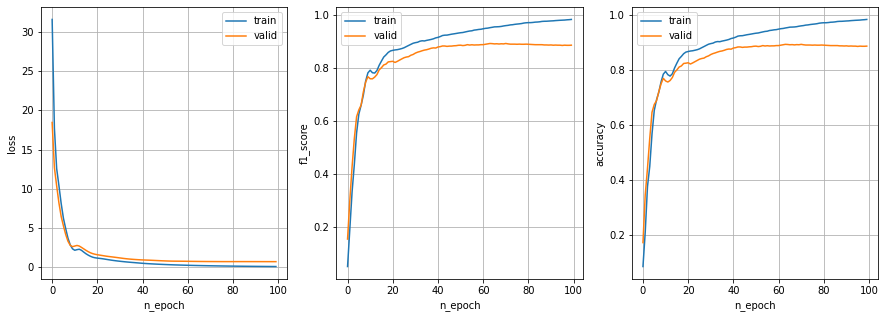

In [ ]:
fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(range(n_epoch), loss_train, label='train')
plt.plot(range(n_epoch), loss_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.subplot(1,3,2)
plt.plot(range(n_epoch), f1_train, label='train')
plt.plot(range(n_epoch), f1_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('f1_score')
plt.legend()
plt.grid()
plt.subplot(1,3,3)
plt.plot(range(n_epoch), acc_train, label='train')
plt.plot(range(n_epoch), acc_valid, label='valid')
plt.xlabel('n_epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()

plt.savefig('./curves_tr_ts.png', bbox_inches='tight')
plt.show()

In [ ]:
model.eval()

Xts = X_test.view(X_test.size(0), -1)
Y_pred = model(Xts)  
loss = criterion(Y_pred,Y_test)

Y_pred = torch.argmax(Y_pred, 1)
f1 = f1_score(Y_test, Y_pred, average='macro')

acc = sum(Y_test == Y_pred)/len(Y_pred)

print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

loss: 0.057037077844142914, f1: 0.9878219490385529, acc: 0.9879032373428345
